In [1]:
## INSTALL SPARK

!apt-get clean
!rm -rf /var/lib/apt/lists/*
!apt-get update
!apt-get upgrade

# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic InRelease [242 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/multivers

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

DetailTransaction = spark.read.option("InferSchema", "true").csv("sample_data/DetailTransaction.csv", header=True)
HeaderTransaction = spark.read.option("InferSchema", "true").csv("sample_data/HeaderTransaction.csv", header=True)
MsCustomer = spark.read.option("InferSchema", "true").csv("sample_data/MsCustomer.csv", header=True)
MsFood = spark.read.option("InferSchema", "true").csv("sample_data/MsFood.csv", header=True)
MsFoodType = spark.read.option("InferSchema", "true").csv("sample_data/MsFoodType.csv", header=True)
MsStaff = spark.read.option("InferSchema", "true").csv("sample_data/MsStaff.csv", header=True)

In [4]:
# test data

DetailTransaction.show(10)

+-------------+------+---+
|TransactionID|FoodID|Qty|
+-------------+------+---+
|            1|     7|  5|
|            2|    23|  7|
|            3|     5|  8|
|            4|    21|  1|
|            5|    11|  2|
|            6|    10|  4|
|            7|     6|  3|
|            8|    22|  6|
|            9|    16|  7|
|           10|    19|  3|
+-------------+------+---+
only showing top 10 rows



In [6]:
DetailTransaction.registerTempTable("DetailTransaction")
HeaderTransaction.registerTempTable("HeaderTransaction")
MsCustomer.registerTempTable("MsCustomer")
MsFood.registerTempTable("MsFood")
MsFoodType.registerTempTable("MsFoodType")
MsStaff.registerTempTable("MsStaff")

<function matplotlib.pyplot.show>

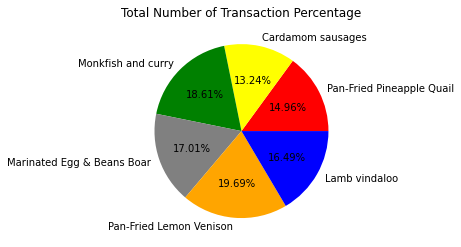

In [14]:
import matplotlib.pyplot as plt

# A. 

res1 = spark.sql(""" 
    SELECT 
      FoodName, SUM(ht.TransactionID) AS Percentage
    FROM HeaderTransaction ht 
    JOIN DetailTransaction dt ON ht.TransactionID = dt.TransactionID
    JOIN MsFood mf ON dt.FoodID = mf.FoodID
    WHERE Price > 300 AND (MONTH(ht.TransactionDate) BETWEEN 6 AND 12) 
    GROUP BY FoodName 
  """)

res1 = res1.toPandas()

# x buat data kita, label -> labels, %% buat special character '%'
plt.pie(res1['Percentage'], labels=res1['FoodName'], autopct='%.2f%%', colors=['red', 'yellow', 'green', 'grey', 'orange', 'blue'])
plt.title("Total Number of Transaction Percentage")
plt.show

+----------------+-----------+
|TransactionMonth|Transaction|
+----------------+-----------+
|               1|         19|
|               2|         22|
|               3|         10|
+----------------+-----------+



<function matplotlib.pyplot.show>

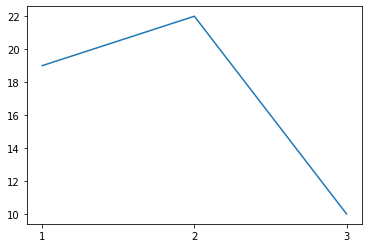

In [28]:
# B.

res2 = spark.sql(""" 
  SELECT 
    MONTH(TransactionDate) AS TransactionMonth,
    COUNT(TransactionID) AS Transaction
  FROM HeaderTransaction ht 
  JOIN MsCustomer mc ON ht.CustomerID = mc.CustomerID
  WHERE YEAR(TransactionDate) = 2021 AND Age > 50
  GROUP BY MONTH(TransactionDate)
  ORDER BY MONTH(TransactionDate)
""")

res2.show()

res2 = res2.toPandas()

plt.plot(res2['Transaction'])
plt.xticks(range(len(res2['TransactionMonth'])), res2['TransactionMonth'])
plt.show

+---------+------+
|    Promo|Number|
+---------+------+
|25% Promo|     1|
|75% Promo|    22|
|50% Promo|     2|
+---------+------+



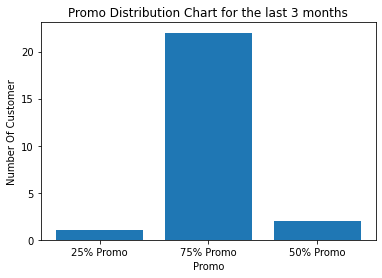

In [45]:
# C
res3 = spark.sql(""" 
  SELECT
    s.Promo, 
    COUNT(s.CustomerID) AS Number
  FROM (SELECT 
    mc.CustomerID,
    COUNT(FoodID) AS Food,
    CASE 
        WHEN COUNT(FoodID) > 100 THEN '75% Promo'
        WHEN COUNT(FoodID) > 75 THEN '50% Promo'
        WHEN COUNT(FoodID) > 50 THEN '25% Promo'
        WHEN COUNT(FoodID) > 5 THEN '10% Promo'
        ELSE '0%'
      END AS Promo
  FROM MsCustomer mc
  LEFT JOIN HeaderTransaction ht ON mc.CustomerID = ht.CustomerID
  LEFT JOIN DetailTransaction dt ON ht.TransactionID = dt.TransactionID
  GROUP BY mc.CustomerID
  ) s
  GROUP BY s.Promo
""")

res3.show()
res3 = res3.toPandas()

# catetan: kalo pake 3 bulan terakhir keluarnya cuman 1 bar doang (yang promo 10% doang), 
# jadinya saya gak pake data 3 bulan terakhir

plt.bar(res3['Promo'], res3['Number'])
plt.title("Promo Distribution Chart for the last 3 months")
plt.xlabel("Promo")
plt.ylabel("Number Of Customer")
plt.show()